# Questions for Dr. Overdorf

1. We understand the need to combine comments into a Reddit feed to allow features to be extracted. However, reddit has a 10,000 character limit on comments, whereas Twitter's is 280. What if we have a 1500-word comment? That doesn't seem compatible with a 500-word document target when comment-splitting isn't allowed, especially when certain features (total words, total chars, count of letters, letter ngrams, digit ngrams, frequency of different word lengths, frequency of function words, frequency of misspellings) operate on an absolute level rather than a proportional level. Perhaps we should filter out comments about 600, 750, or 1000 words. The problem with this is longer comments might've received more writing care, and if we are tasked with classifying a longer comment, we didn't prepare for it. Also, even without the longer comments, the question of properly combining comments stands.

We can split comments up, but make sure we aren't double-inclduing it when we do cross-validation. When she did tweets she excluded parts of comments. We can just try with larger than 500 comments, but better ohave nearly 500. Try and get 10 docs per author. 

In terms of time, make sure we only take the past year. Can also take the last 5000 words. 

It isn't innapropriate to exclude non-active users. 

No industry accepted package for writeprints. We can do manually, but also check if packages are released as part of a peer-reviewed paper. 

2. Right now we are removing comments which are exclusively a link, emojis, numbers, ASCII art, and punctuation. Links, for example, should be removed no matter what. With other types of removals it isn't so clear - numbers, emojis, and punctuation are all relevant to feature creation. Is there any issue to adding such comments to 500-word Reddit feeds? Are we perhaps adding 'padding' to our 500 word documents?

Much more resilient against problem of non-english tweets in overdorf paper; they tossed out accounts that weren't fully in english. Can try, but might lose us a lot of data. Advanced method: manually flag a subset. Check this set against our processing, and determine if we're successful enough. Skim and see if our methods work. 

3. In Dr. Overdorf's paper she tries removing lexical features from the set in cross-domain analysis. The hope is that function word usage will be simliar regardless of conversational context. Wouldn't removing content features (word ngrams) be necessary as well? Would this scenario apply to our reddit comments since they're taken across multiple different subreddits?

Completely a lie that ngrams are independent from topic. Okay, this problem is too big for us to tackle. Put a sentence: 'we didn't control for difference in topics between subreddits'. 

4. In Dr. Overdrof's paper, she is performing her analysis on up to 50 authors at a time, sampling from the 200 authors with 5000 or more words in each domaind's corpus. Practically, does this mean we random-sample up to 50 authors for each run of a model and perform several runs with different author sets when arriving at classification accuracy figures? Did she ever deviate from that sample of 50? Side note: is limiting our study to 50 authors or less the reason false negatives don't matter in the heuristic? 

It actually does matter if we miss english. 

5. Does the time aspect matter here? I suppose we assume non-native speakers aren't substantially increasing their language level within our three month comment timeframe - and nor has their language level changed between the comments and when we took the flair value.

We can control for this. 

6. Non-english comments need to be removed before aggregation into 500-word document. But performing a filter on individual comments tends to exclude short comments with misspellings or slang.

7. Contractions. Many articles suggest lummaization to arrive at pre-feature-development words. Lemmaization will convert a contraction like isn't into is not, correct? But aren't we sacrificing important information (the use of contractions vs not) by performing this transformation?


8. Should we be considering a none-of-the-above option?


9. What exactly is the research question? This will inform the process we use. On the one hand, we could split our authors up before doing any preprocessing or training. Then develop a different model for each and find our highest result. This will tell us: which level of language proficiency leaves the most clues. On the other hand, we could preprocess and train our different language levels together. Then, see how well classification is for each language level using the SAME model. This will tell us how powerful our universal-use tool is based on the target author's proficiency. 

We can do either. The results will correlate. The first one is more interesting for real world application. Disparate impact. Run a few different types of models, involve different splits (native to non-native, native vs a vs b vs c). Spanish, german, and french will be much more interesting, because they have a more even distribution in level proficiency than english. Proof of concept - means we don't need too much data in each group. Only need to show it 'doesn't work'. DOn't necessarily need 5000 because of k-fold cross validation. 

10. If 4500 words for train and 500 for test, isn't that just one test doc per author? Isn't that low?

11. If we have only 50 authors and train one model on all 50, would we have enough data? Because then we've got 12-13 author per language category. 



Important parts are making sure the prepackaged methods are not applied discriminately. Make sure we do our k-fold cross validation correectly, our train/test correctly.


Try SVMs first and go from there. 

At least 4grams. 

In [51]:
import os, json
import pandas as pd
from pathlib import Path
import re
from collections import Counter
import numpy as np
import nltk
import time
from PIL import Image
from wordcloud import WordCloud
import matplotlib.pyplot as plt
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from writeprints.text_processor import Processor
import string
import spacy
from langdetect import DetectorFactory
from langdetect import detect_langs
from sklearn.preprocessing import LabelEncoder
from sklearn import svm, datasets
import sklearn.model_selection as model_selection
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
import ast 

[nltk_data] Downloading package wordnet to /home/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to /home/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Paper Summary

## Types of Features

1. Lexical features: word or character-based statistical measures of lexical variation.
     -  Sentence/line length [Yule 1938; Argamon et al. 2003]
     -  Vocabulary richness [Yule 1944]
     -  Word-length distributions [De Vel et al. 2001; Zheng et al. 2006]

2.  Syntactic features
    -  function words [Mosteller and Wallace 1964]
        -   Shown to be highly effective discriminators of authorship, since the usage variations of such words are a strong reflection of stylistic choices [Koppel et al. 2006]
    -  punctuation [Baayen et al. 2002]
    -  part-of-speech tag n-grams [Baayen et al. 1996; Argamon et al. 1998]

3.  Structural features - especially useful for online text
    -  attributes relating to text organization and layout [De Vel et al. 2001; Zheng et al. 2006]
    -  technical features such as the use of various file extensions, fonts, sizes, and colors [Abbasi and Chen 2005]
    -  When analyzing computer programs, different structural features (e.g., the use of braces and comments) are utilized [Oman and Cook 1989].

4.  Content-specific features are comprised of important keywords and phrases on certain topics [Martindale and McKenzie 1995]
    -  word n-grams [Diederich et al. 2003]. 
        -  For example, content-specific features on a discussion of computers may include “laptop” and “notebook.”

5.  Idiosyncratic features 
    -  misspellings
    -  grammatical mistakes
    -  other usage anomalies. 
    -  Such features are extracted using spelling and grammar checking tools and dictionaries [Chaski 2001; Koppel and Schler 2003]
    -   May also reflect deliberate author choices or cultural differences, such as use of the word “center” versus “center” [Koppel and Schler 2003].
    
The use of feature sets containing lexical, syntactic, structural, and syntactic features has been shown more effective for online identification than feature sets containing only a subset of these feature groups [Abbasi and Chen 2005; Zheng et al. 2006].

## Techniques

### Supervised techniques 

1. support vector machines (SVMs) [Diederich 2000; De Vel 2001; Li et al. 2006]
    - highly robust technique that has provided powerful categorization capabilities for online authorship analysis.
    - In head-to-head comparisons, SVM significantly outperformed other supervised learning methods such as neural networks and decision trees [Abbasi and Chen 2005; Zheng et al. 2006].
2. neural networks [Merriam 1995; Tweedie et al. 1996; Zheng et al. 2006]
3. decision trees [Apte 1998; Abbasi and Chen 2005]
4. linear discriminant analysis [Baayen 2002; Chaski 2005]

### Unsupervised stylometric categorization techniques 
1. cluster analysis [Holmes 1992]
2. principal component analysis (PCA) [Burrows 1987, Baayen et al. 1996]
    - Ability to capture essential variance across large numbers of features in a reduced dimensionality makes it attractive for text analysis problems, which typically involve large feature sets
    - Also been shown effective for online stylometric analysis [Abbasi and Chen 2006]

Supervised techniques are those that require author-class labels for categorization, while unsupervised techniques make categorizations with no prior knowledge of author classes. __Kaede note:__ Can we can use unsupervised techniques for similarity detection to merge duplicate accounts?

## Miscellaneous

__Kaede note:__ We are studying what the paper calls "Asynchronous CMC" and labels "D1". We are tackling the message-level identification task.

Message-level analysis is not highly scalable to larger numbers of authors in cyberspace due to difficulties in consistently identifying texts shorter than 250 words [Forsyth and Holmes 1996]
__Kaede note:__ In her email, Dr. Overdorf says we should "not be afraid of combining or grouping comments together to deal with the fact that some of them are quite short. Just be clever about it and make sure you don’t split any single comment up." 

Example of stylometry focusing on "feedback comments" is [Hayne and Rice 1997; Hayne et al. 2003]. Feature sets used in previous online studies typically consist of a handful of categories and less than 500 features. Two types of feature sets have been used in previous research: author-group level and individual-author level

__Kaede note:__ 2.3.1 Individual-Level Techniques; Struggled to understand this section and determine if it was relevant to us

## Main Paper Technique: Writeprints

Writeprints is a Karhunen-Loeve-transforms-based technique that uses a sliding window and pattern disruption to capture feature usage variance at a finer level of granularity. The use of individual-author-level feature sets is intended to provide greater scalability as compared to traditional machine learning techniques that only utilize a single author-group-level set (e.g., SVM, PCA).

### System Design

#### 5.1 Feature Extraction
1. All message signatures are initially filtered out in order to remove obvious identifiers [De Vel et al. 2001]
2. Two feature sets:
    1. a baseline feature set (BF) consisting of static author-group-level features
        - "fairly straightforward extraction procedure"
    2. an extended feature set (EF) consisting of static and dynamic features.
    

    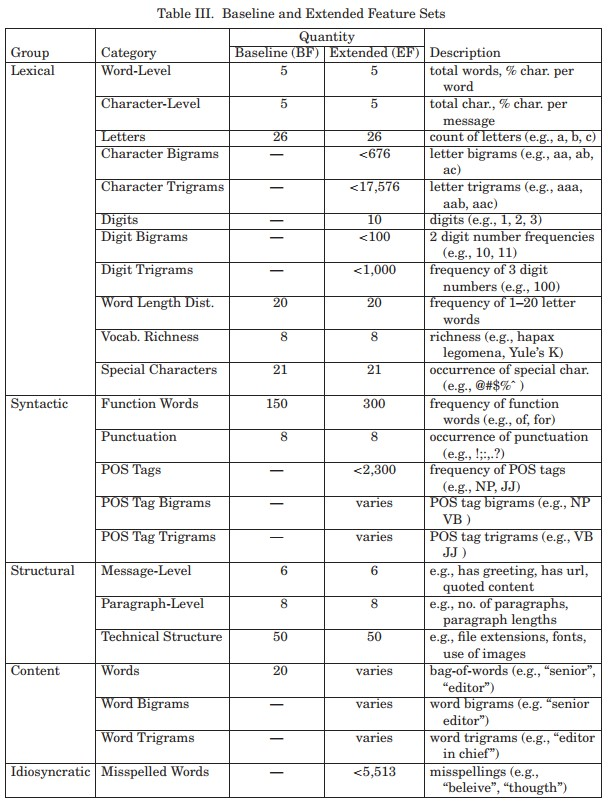

# Notes from Dr. Overdorf's Paper

We should take up to 50 authors with 5,000 words or more. Be sure to pull from each level of proficiency.
- "We collected thousands of users’ data, but only about 200 users had enough data in each domain (10,000 words) for us to consider. Our experiments utilize a random subset of these authors as experiments beyond 50 authors are computationally expensive. Previous work in stylometry (in-domain) has suggested that 4,500 words is sufficient for a good training model and 500 words for a good test document [3]. Therefore, 10,000 words allows us enough data to train a model for each domain and test it using cross-validation."

Perhaps we create a 'Reddit feed' similar to how she creates a 'Twitter feed'
- "For all of the data used in this work, we grouped the documents into 500 word documents. This creates consistency for each experiment. We use the term Twitter feed to mean a group of tweets that is at least 500 words long. This changes the question from Who wrote this tweet? to Whose Twitter feed is this?. This is just as practical a question, as often the author of an anonymous Twitter account comes into question and rarely is it the case that a such a Twitter feed would contain only one tweet. Practically, using Twitter feeds instead of individual tweets means that each test case has more text from which we can extract features. This has been tested in the literature [9, 26] on authorship attribution of tweets to great success."
- "For consistency here and throughout this work, we partitioned all of the data into 500 word documents and guarantee that no text from any post was split between documents. This ensures that we never try to classify a document in which some of the text comes from the same post or entry as a training document, as that will artificially inflate results."

Logistic Regression once again baybeeeeee. But let's implement them all and have a nice table where we show performance by model-english proficiency combinations
- "For classification we use logistic regression as implemented in scikit-learn6. Half of the data is used as training documents to build our classifier and the other half is set aside as test documents. "
- "The classifier used in prior stylometry work has varied; Brennan et al. use a linear SVM [11], Narayanan et al. use regularized least squares classification(RLSC) [28], Abbasi and Chen use both a customized K-L transform combined with a euclidean distance measure and a linear SVM with similar results [1]."
- "Generally speaking, for linearly separable problems, regularized linear classifiers will perform similarly. Our indomain results and those in previous studies, show that
stylometry is a linearly separable problem on which linear classifiers perform well."

We should try using only non-lexical features 
- "We aim to remove the concept of context or subject from the feature extraction phase by using only non-lexical features. This idea comes from [27]... They were able to increase accuracy when classifying books written in different genres by using only function words."

Another round of epic PCA analysis anyone???
- "Recursive Feature Elimination [16] is a method used with linear classifiers to determine the importance of features and reduce dimensionality through recursively reducing the number of features by eliminating those with the smallest weight."

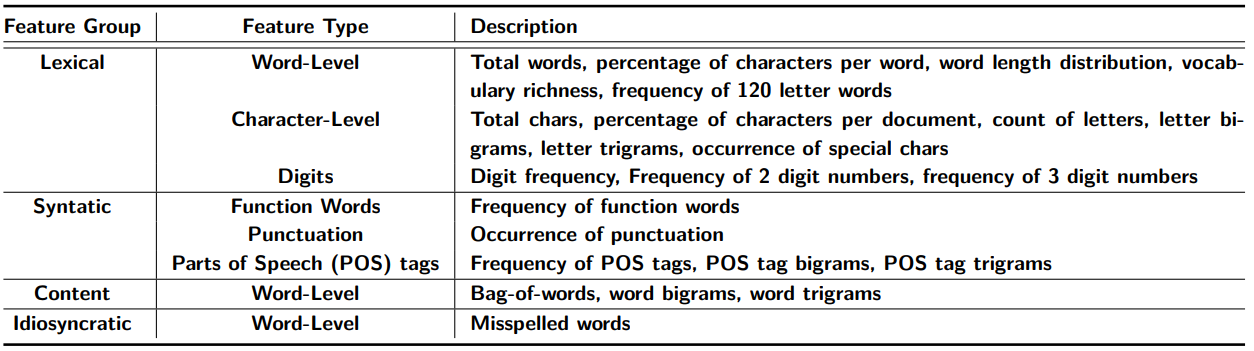

# Data Pre-Processing

## Find 5 most frequent commenters by proficiency in english; these will be our sample for model development

In [2]:
# Find authors with 5000 or more words

user_levels = pd.read_csv('user_levels.csv')
# Fix up flair-to-proficiency map
# TODO
# Booleanize proficiency columns, true if column contains en
user_levels['N'] = user_levels['N'].str.contains('en')
user_levels['A1'] = user_levels['A1'].str.contains('en')
user_levels['A2'] = user_levels['A2'].str.contains('en')
user_levels['B1'] = user_levels['B1'].str.contains('en')
user_levels['B2'] = user_levels['B2'].str.contains('en')
user_levels['C1'] = user_levels['C1'].str.contains('en')
user_levels['C2'] = user_levels['C2'].str.contains('en')
# Keep authors with 'en' listed in one column and one column only
user_levels = user_levels.iloc[list(user_levels[['N', 'A1', 'A2', 'B1', 'B2', 'C1', 'C2']].sum(axis = 1).loc[lambda x : x == 1].keys())]
user_levels['proficiency'] = ""
user_levels['proficiency'].mask(user_levels['N']==True, 'N', inplace=True)
user_levels['proficiency'].mask(user_levels['A1']==True, 'A1', inplace=True)
user_levels['proficiency'].mask(user_levels['A2']==True, 'A2', inplace=True)
user_levels['proficiency'].mask(user_levels['B1']==True, 'B1', inplace=True)
user_levels['proficiency'].mask(user_levels['B2']==True, 'B2', inplace=True)
user_levels['proficiency'].mask(user_levels['C1']==True, 'C1', inplace=True)
user_levels['proficiency'].mask(user_levels['C2']==True, 'C2', inplace=True)
user_levels['proficiency'].value_counts()
user_levels = user_levels[['author','proficiency']]
user_levels.to_csv('author_proficiency.csv')

## Aggregate data and push to csv

In [3]:
# this finds our json files
path_to_json = 'user_comments/'
json_files = [pos_json for pos_json in os.listdir(path_to_json) if pos_json.endswith('.json')]

# here I define my pandas Dataframe with the columns I want to get from the json
#jsons_data = pd.DataFrame(columns=['author', 'body', 'created_utc', 'edited', 'id', 'is_submitter', 'link_id', 'parent_id', 'score', 'subreddit', 'subreddit_id'])
print(len(json_files))
df = pd.DataFrame()
for i in range(len(json_files)):
    if (i != 532) & (i != 991):
        with open(os.path.join(path_to_json, json_files[i])) as fp:
            data = json.loads(fp.read())
            tmp = pd.DataFrame.from_dict(data)
            df = pd.concat([df, tmp])
    if (i == 532) | (i == 991):
        print("Corrupted: File #" + str(i) + ", " + json_files[i])

filepath = Path('cmts_agg.csv')    
df.to_csv('cmts_agg.csv')

1535
Corrupted: File #532, an_average_potato_1.json
Corrupted: File #991, jlba64.json


## Create subset for pilot model development

In [4]:
# Isolate the five most prolific commenters by english efficiency
df2 = (df.groupby(['author']).size()).to_frame(name = "cmts_freq")
author_proficiency = pd.read_csv('author_proficiency.csv')
author_freqs_proficiency = pd.merge(author_proficiency, df2, how='left',on='author')
author_freqs_proficiency = author_freqs_proficiency.sort_values(['proficiency','cmts_freq', 'author'],ascending=False).groupby('proficiency').head(5)
author_freqs_proficiency = author_freqs_proficiency[['author','proficiency']]
author_freqs_proficiency.to_csv('author_freqs_proficiency.csv')
df = pd.merge(author_freqs_proficiency, df, how='left', on='author')

# Save
df.to_csv('cmts_sample.csv')

# From Dr. Overdorf's paper: only about 200 users had enough data in each domain (10,000 words) for us to consider

## Isolate Text in Sample Data

In [29]:
cmts = pd.read_csv('cmts_sample.csv')
cmts = cmts[['author', 'body', 'proficiency']].rename(columns={"body": "text"})
cmts['text'] = cmts['text'].astype(str)

## Remove non-text comments, filter to English comments

In [30]:
# langdetect non-deterministic... need seed for consistent results
DetectorFactory.seed = 5
# First we remove rows that aren't helpful as language. In this initial stage it's anything detect_langs
# cannot put a language on. This includes comments which are solely:
# 1. A link
# 2. Emojis (one comment contains a few words but is otherwise overwhelmingly emoji)
# 3. Numbers (including time, height, year)
# 4. ASCII art
# 5. Formatted country/state code (🇨🇦 🇨🇩 🇩🇪 🇮🇹 🇮🇩 🇭🇺 🇱🇺). These are emojis on phones, formatted letters on computers
# 6. Punctuation
#
# We should write these exceptions into our code manually in the future. Right now I loop through all rows
# trying the detect_langs method because if I use .apply on cmts the problematic rows cause
# an error. If we remove problematic rows beforehand we can avoid this loop and use .apply.

cmts['text_langs'] = ''
cmts['droppable'] = 0
for index, row in cmts.iterrows():
    try:
        text_langs = detect_langs((row['text']))
        cmts.at[index,'text_langs'] = text_langs
    except:
        cmts.at[index,'droppable'] = 1
cmts = cmts[cmts['droppable'] == 0]
cmts = cmts.drop(['droppable'], axis=1)

# Next we remove non-english comments. This is a difficult task. Will typos be caught? Will slang be caught?
# Will proper nouns and places be caught? The comment 'fuuuuuuuck uuuuuuutah' isn't considered english. Neither
# is 'fuck utah'. Sorry for not choosing a cleaner example, this one staring me in the face at the head of my
# dataset.

def keep_highestprob_en(lang_list):
    return str(lang_list[0]).startswith('en:')
cmts['text_lang_en'] = cmts['text_langs'].apply(keep_highestprob_en)
cmts[cmts['text_lang_en'] == False].to_csv('cmts_sample_non_eng.csv')
cmts = cmts[cmts['text_lang_en'] == True]
cmts = cmts.drop(['text_lang_en', 'text_langs'], axis=1)

cmts.to_csv('cmts_sample_preprocessed.csv')

#### First attempt at english: use nltk corpus to identify english words
#### I abandoned this after my first example ('fuuuuuuuch uuuuuuuuuuuutah') didn't register
#### any english words, even without the misspellings. Of course, the method I switched to
#### doesn't either :)
####
####    nltk.download('words')
####    for w in nltk.wordpunct_tokenize(cmts['text'][2]):
####        print(w.lower())
####        print(w.lower() in set(nltk.corpus.words.words()))

# https://levelup.gitconnected.com/text-cleansing-in-nlp-tasks-594b93d648d6

# Remove certain characters? Looks like some characters didn't read into python properly; handle these how?
# Remove stop words? I think not so early; % of stop words in comment could be helpful as a feature
# Remove punctuation? Contractions?
# Doppelganger Finder Algorithm: how to link users with multiple accounts 
# Remove all links for sure

# Calculate Features

In [17]:
# So we don't have to reload cmts each time, we will modify a version of base json data called cmts_aug
cmts = pd.read_csv('cmts_sample_preprocessed.csv')
cmts_aug = cmts

def tokenizer(feed, spacy_load):
    return spacy_load(feed)

def tokenizer_wrapper(dataframe, textcolumn, spacy_load):
    if 'text_tokenized' not in dataframe.columns:
        print("Tokenizing feeds...")
        baseline = time.time()
        dataframe['text_tokenized'] = dataframe['text'].apply(tokenizer, args=(spacy_load,))
        print("Feeds tokenized in " + str(time.time() - baseline) + " seconds")
    else:
        print("Feeds already tokenized")

In [ ]:
trainset = []
i = 0
for row in cmts_aug.iterrows():
    trainset.append({"label":row[1][1], "text":row[1][2]})
    
# https://www.youtube.com/watch?v=dBqyvpfHy8k

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import FeatureUnion
word_vector = TfidfVectorizer(analyzer="word", ngram_range=(1,3), max_features = 2000, binary = False)
char_vector = TfidfVectorizer(analyzer="char", ngram_range=(1,4), max_features = 2000, binary = False, min_df = 0)
corpus = []
classes = []
for item in trainset:
    corpus.append(item["text"])
    classes.append(item["label"])
vectorizer = FeatureUnion([("chars", char_vector),("words", word_vector)])
X = vectorizer.fit_transform(corpus)

import nltk
def pos_tags(txt):
    tokens = nltk.word_tokenize(txt)
    return " ".join( [ tag for (word, tag) in nltk.pos_tag( tokens ) ] )
tags = pos_tags(' '.join(corpus))
tag_vector = TfidfVectorizer( analyzer="word", ngram_range=(2,2), binary = False, max_features = 2000, decode_error='ignore')
X1 = vectorizer.fit_transform(corpus)
X2 = tag_vector.fit_transform([tags])
X = np.hstack((X1,X2), format='csr')

model = LinearSVC( loss='l1', dual = True)
scores = cross_validation.cross_val_score( estimator = model, X = matrix.toarray(), y = np.asarray(classes), cv = 10)
print("10-fold cross validation results:", "mean scores = ", scores.mean(), "std=", scores.std(), ", num folds =", len(scores))

### Letter n-grams, Digit 1-gram, Punctuation 1-gram

In [14]:
# Character Counts, Character 2-Grams, Character 3-Grams, Character 4-Grams, Digit Counts, Punctuation Counts

def character_ngrams(feed, collection, kind):
    feed_lower = feed.lower()
    lhs = ['feed_lower.count(\''] * len(collection)
    rhs = ['\')'] * len(collection)
    char_ngrams = []
    for p1, p2, p3 in zip(lhs, collection, rhs):
        command = p1 + p2 + p3
        if (p2 != ('\\' + string.punctuation[6])) & (p2 != ('\\\\')):
            command = command.replace('\\', '', 1)
        char_ngrams.append(eval(command))
    num_chars = sum(char_ngrams)
    if num_chars == 0:
        num_chars = 1
    return [x / num_chars for x in char_ngrams]

def character_ngrams_wrapper(dataframe, textcolumn, newcolumn, n, kind='letter'):
    print("Performing " + kind + " " + str(n) + "-gram...")
    baseline = time.time()
    if kind == 'letter':
        collection = list(string.ascii_lowercase)
    if kind == 'digit':
        collection = list(string.digits)
    if kind == 'punctuation':
        collection_temp = list(string.punctuation)
        collection = ['\\' + a for a in collection_temp]
    if n == 2:
        collection = [a + b for a in collection for b in collection]
    if n == 3:
        collection = [a + b + c for a in collection for b in collection for c in collection]
    if n == 4:
        collection = [a + b + c + d for a in collection for b in collection for c in collection for d in collection]
    dataframe[newcolumn] = dataframe[textcolumn].apply(character_ngrams, args = (collection,kind))
    print("Performed " + kind + " " + str(n) + "-gram in " + str(time.time() - baseline) + " seconds")

character_ngrams_wrapper(cmts_aug, 'text', 'letter_1gram', 1, 'letter')
character_ngrams_wrapper(cmts_aug, 'text', 'letter_2gram', 2, 'letter')
#character_ngrams_wrapper(cmts_aug, 'text', 'letter_3gram', 3, 'letter')
#character_ngrams_wrapper(cmts_aug, 'text', 'letter_4gram', 4, 'letter')
character_ngrams_wrapper(cmts_aug, 'text', 'digit_1gram', 1, 'digit')
character_ngrams_wrapper(cmts_aug, 'text', 'punctuation_1gram', 1, 'punctuation')

Performing letter 1-gram...
Performed letter 1-gram in 4.506972551345825 seconds
Performing letter 2-gram...
Performed letter 2-gram in 115.20170545578003 seconds
Performing digit 1-gram...
Performed digit 1-gram in 1.7848033905029297 seconds
Performing punctuation 1-gram...
Performed punctuation 1-gram in 5.454233884811401 seconds


### Character Count, Alphabet Count & Proportion, Digit Count & Proportion, Punctuation Count & Proportion

In [15]:
def character_count_proportion(feed, collection, kind):
    feed_lower = feed.lower()
    #feed_lower_no_ws = feed.translate({ord(c): None for c in string.whitespace}).lower() # removes spaces and linebreaks
    if kind != "character":
        match = []
        for char in feed_lower:
            if char in collection:
                match.append(1)
            else:
                match.append(0)
        return sum(match), sum(match) / len(match)
    if kind == "character":
        return len(feed_lower), 1
              
def character_count_proportion_wrapper(dataframe, textcolumn, kind='letter'):
    print("Performing " + kind + " count & proportion...")
    baseline = time.time()
    if kind == 'letter':
        collection = list(string.ascii_lowercase)
    if kind == 'digit':
        collection = list(string.digits)
    if kind == 'punctuation':
        collection = list(string.punctuation)
    if kind == 'whitespace':
        collection = list(string.whitespace)
    if kind == 'character':
        collection = ['only included for the sake of function call']
    dataframe[kind + '_count_prop'] = dataframe[textcolumn].apply(character_count_proportion, args = (collection,kind))
    dataframe[[kind + '_count', kind + '_prop']] = pd.DataFrame(dataframe[kind + '_count_prop'].tolist(), index=dataframe.index)
    dataframe = dataframe.drop([kind + '_count_prop'], axis = 1)
    if kind == "character":
            dataframe = dataframe.drop([kind + '_prop'], axis = 1)
    print("Performed " + kind + " count & proportion in " + str(time.time() - baseline) + " seconds")
    return dataframe

cmts_aug = character_count_proportion_wrapper(cmts_aug, 'text', 'letter')
cmts_aug = character_count_proportion_wrapper(cmts_aug, 'text', 'digit')
cmts_aug = character_count_proportion_wrapper(cmts_aug, 'text', 'punctuation')
cmts_aug = character_count_proportion_wrapper(cmts_aug, 'text', 'whitespace')
cmts_aug = character_count_proportion_wrapper(cmts_aug, 'text', 'character')

Performing letter count & proportion...
Performed letter count & proportion in 1.2341313362121582 seconds
Performing digit count & proportion...
Performed digit count & proportion in 0.9845657348632812 seconds
Performing punctuation count & proportion...
Performed punctuation count & proportion in 2.0594520568847656 seconds
Performing whitespace count & proportion...
Performed whitespace count & proportion in 0.7459962368011475 seconds
Performing character count & proportion...
Performed character count & proportion in 0.03933572769165039 seconds


### Word Count, Average Word Length, Word Length Distribution (Freq of words length 1-20 letters), Word Case Distribution (All lowercase / First-upper-rest-lowercase / All uppercase / Other), Character case distribution (lowercase / uppercase)

In [16]:
def word_list(feed):
    return re.sub(r'[^a-zA-Z ]+', '', feed).split()

def word_count(feed):
    words = word_list(feed)
    total_words = len(words)
    return total_words

def word_length_avg(feed):
    words = word_list(feed)
    word_lengths = []
    for word in words:
        word_lengths.append(len(word))
    return sum(word_lengths) / len(word_lengths)
    
def word_length_distribution(feed):
    words = word_list(feed)
    word_lengths = []
    for word in words:
        word_lengths.append(len(word))
    wc = len(word_lengths)
    word_lengths.extend(range(1,21))
    word_lengths.sort()
    length_distro_temp = list(Counter(word_lengths).values())
    length_distro = [(x-1)/wc for x in length_distro_temp]
    return length_distro

def word_short_prop(word_length_distribution):
    return sum(word_length_distribution[0:3])

def letter_case_distribution(feed):
    lc_count=0
    for char in feed:
        if(char.islower()):
            lc_count += 1

    uc_count=0
    for char in feed:
        if(char.isupper()):
            uc_count += 1
    
    total = lc_count + uc_count
    return [lc_count/total, uc_count/total]

def word_case_distribution(feed):
    all_lower_word = 0
    all_upper_word = 0
    first_upper_rest_lower_word = 0
    other_word = 0

    # Strips string of everything except letters and spaces
    ## Q: Should we remove single-letter words?? "I" possibly inflating uppercase word proportions...
    words = word_list(feed)
    
    total_words = len(words)
    for word in words:
        char_distro = letter_case_distribution(word)
        if char_distro[0] == 1:
            all_lower_word += 1
        elif char_distro[1] == 1:
            all_upper_word += 1
        else:
            if word[0].isupper() and char_distro[1] == 1/len(word):
                first_upper_rest_lower_word += 1
            else:
                other_word += 1

    return [all_lower_word / total_words, first_upper_rest_lower_word / total_words, all_upper_word / total_words, other_word / total_words]

def word_count_wrapper(dataframe, textcolumn):
    print("Performing word count...")
    baseline = time.time()
    dataframe['word_count'] = dataframe[textcolumn].apply(word_count)
    print("Performed word count in " + str(time.time() - baseline) + " seconds")
    
def word_length_avg_wrapper(dataframe, textcolumn):
    print("Performing word length avg...")
    baseline = time.time()
    dataframe['word_length_avg'] = dataframe[textcolumn].apply(word_length_avg)
    print("Performed word length avg in " + str(time.time() - baseline) + " seconds")
    
def word_length_distribution_wrapper(dataframe, textcolumn):
    print("Performing word length distribution...")
    baseline = time.time()
    dataframe['word_length_distribution'] = dataframe[textcolumn].apply(word_length_distribution)
    print("Performed word length distribution in " + str(time.time() - baseline) + " seconds")
    
def word_short_count_wrapper(dataframe, word_length_distribution, word_count):
    if word_length_distribution not in dataframe.columns or word_count not in dataframe.columns:
        print("missing required columns")
        return
    print("Performing word count short...")
    baseline = time.time()
    dataframe['word_short_prop'] = dataframe[word_length_distribution].apply(word_short_prop)
    dataframe['word_short_count'] =  dataframe['word_short_prop']*dataframe[word_count]
    print("Performed word count short in " + str(time.time() - baseline) + " seconds")

def letter_case_distribution_wrapper(dataframe, textcolumn):
    print("Performing letter case distribution...")
    baseline = time.time()
    dataframe['letter_case_distribution'] = dataframe[textcolumn].apply(letter_case_distribution)
    print("Performed letter case distribution in " + str(time.time() - baseline) + " seconds")
    
def word_case_distribution_wrapper(dataframe, textcolumn):
    print("Performing word case distribution...")
    baseline = time.time()
    dataframe['word_case_distribution'] = dataframe[textcolumn].apply(word_case_distribution)
    print("Performed word case distribution in " + str(time.time() - baseline) + " seconds")

word_count_wrapper(cmts_aug, 'text')
word_length_avg_wrapper(cmts_aug, 'text')
word_length_distribution_wrapper(cmts_aug, 'text')
word_short_count_wrapper(cmts_aug, 'word_length_distribution', 'word_count')
letter_case_distribution_wrapper(cmts_aug, 'text')
word_case_distribution_wrapper(cmts_aug, 'text')

Performing word count...
Performed word count in 0.20452070236206055 seconds
Performing word length avg...
Performed word length avg in 0.26403045654296875 seconds
Performing word length distribution...
Performed word length distribution in 0.5139124393463135 seconds
Performing word count short...
Performed word count short in 0.013106584548950195 seconds
Performing letter case distribution...
Performed letter case distribution in 1.433652400970459 seconds
Performing word case distribution...
Performed word case distribution in 0.873204231262207 seconds


### POS n-grams, Stop Word proportion of Tokens

In [17]:
def POS_tags_ngram(tokens, n, collection):
    tc = len(tokens)
    tags = []
    for token in tokens:
        #print(f'{token.text:{12}} {token.pos_:{10}} {token.tag_:{8}} {spacy.explain(token.tag_)}')
        tags.append(token.tag_)
    ngrams = []
    for i in range(tc-(n-1)):
        ngrams.append(tags[i:i+n])
    ngrams_sortable = []
    for i in range(len(ngrams)):
        ngrams_sortable.append('||'.join(ngrams[i]))
    ngrams_sortable = ngrams_sortable + collection
    ngrams_sortable.sort()
    tags_ngram_distro_temp = list(Counter(ngrams_sortable).values())
    tags_ngram_distro = [(x-1)/tc for x in tags_ngram_distro_temp]
    return tags_ngram_distro

def stop_words_proportion(tokens, collection):
    tc = len(tokens)
    stop_words = 0
    for token in tokens:
        if token.text in collection:
            stop_words += 1
    return stop_words / tc

def POS_tags_ngram_wrapper(dataframe, textcolumn, newcolumn, n):
    sp = spacy.load('en_core_web_sm')
    tokenizer_wrapper(dataframe, textcolumn, sp) 
    print("Performing POS tags " + str(n) + "-grams...")
    baseline = time.time()
    collection = sp.pipe_labels['tagger']
    if n == 1:
        pass
    if n == 2:
        collection = [a + "||" + b for a in collection for b in collection]
    if n == 3:
        collection = [a + "||" + b + "||" + c for a in collection for b in collection for c in collection]
    dataframe[newcolumn] = dataframe[textcolumn + '_tokenized'].apply(POS_tags_ngram, args=(n, collection))
    print("Performed POS tags " + str(n) + "-gram in " + str(time.time() - baseline) + " seconds")
    
def stop_words_proportion_wrapper(dataframe, textcolumn, newcolumn):
    sp = spacy.load('en_core_web_sm')
    tokenizer_wrapper(dataframe, textcolumn, sp)
    print("Performing stop words ratio...")
    baseline = time.time()
    collection = list(sp.Defaults.stop_words)
    dataframe[newcolumn] = dataframe[textcolumn + '_tokenized'].apply(stop_words_proportion, args = (collection,))
    print("Performed stop words ratio in " + str(time.time() - baseline) + " seconds")
    
POS_tags_ngram_wrapper(cmts_aug, 'text', 'POS_tag_1gram', 1)
#POS_tags_ngram_wrapper(cmts_aug, 'text', 'POS_tag_2gram', 2)
#POS_tags_ngram_wrapper(cmts_aug, 'text', 'POS_tag_3gram', 3)
stop_words_proportion_wrapper(cmts_aug, 'text', 'stop_words_proportion')

Tokenizing feeds...
Feeds tokenized in 215.7714946269989 seconds
Performing POS tags 1-grams...
Performed POS tags 1-gram in 1.5273187160491943 seconds
Feeds already tokenized
Performing stop words ratio...
Performed stop words ratio in 2.881333351135254 seconds


### Vocabulary Richness: Hapax Legomena Proportion of Total Tokens, Hapax Legomena Proportion of Unique Tokens, Unique Tokens over Total Tokens

In [20]:
# https://eprints.qut.edu.au/8019/1/8019.pdf

def hapax_legomena_proportion(tokens, kind):
    token_texts = []
    for token in tokens:
        token_texts.append(token.text)
    if kind == 'total':
        denominator = len(token_texts)
    elif kind == 'unique':
        denominator = len(list(set(token_texts)))
    c = Counter(token_texts)
    hapleg_token = 0
    for token in c:
        if c[token] == 1:
            hapleg_token += 1
    return hapleg_token / denominator

def token_type_ratio(tokens):
    token_texts = []
    for token in tokens:
        token_texts.append(token.text)
    total = len(token_texts)
    unique = len(list(set(token_texts)))
    return unique / total

def hapax_legomena_proportion_wrapper(dataframe, textcolumn, newcolumn, kind):
    sp = spacy.load('en_core_web_sm')
    tokenizer_wrapper(dataframe, textcolumn, sp)
    print("Performing hapax legomena proportion of " + kind + " tokens...")
    baseline = time.time()
    dataframe[newcolumn] = dataframe[textcolumn + '_tokenized'].apply(hapax_legomena_proportion, args = (kind,))
    print("Performed hapax legomena proportion of " + kind + " tokens in " + str(time.time() - baseline) + " seconds")

def token_type_ratio_wrapper(dataframe, textcolumn, newcolumn):
    sp = spacy.load('en_core_web_sm')
    tokenizer_wrapper(dataframe, textcolumn, sp)
    print("Performing token type ratio...")
    baseline = time.time()
    dataframe[newcolumn] = dataframe[textcolumn + '_tokenized'].apply(token_type_ratio)
    print("Performed token type ratio in " + str(time.time() - baseline) + " seconds")

hapax_legomena_proportion_wrapper(cmts_aug, 'text', 'hapax_legomena_prop_tot_tokens', 'total')
hapax_legomena_proportion_wrapper(cmts_aug, 'text', 'hapax_legomena_prop_unique_tokens', 'unique')
token_type_ratio_wrapper(cmts_aug, 'text', 'token_type_ratio')


Feeds already tokenized
Performing hapax legomena proportion of total tokens...
Performed hapax legomena proportion of total tokens in 0.6965935230255127 seconds
Feeds already tokenized
Performing hapax legomena proportion of unique tokens...
Performed hapax legomena proportion of unique tokens in 0.7848000526428223 seconds
Feeds already tokenized
Performing token type ratio...
Performed token type ratio in 0.6002283096313477 seconds


In [21]:
cmts_aug.to_csv('cmts_aug.csv')

https://github.com/pagea/unstyle/issues/1

letter trigrams IMPLEMENTED BUT NOT OPTIMIZED<br>
occurrence of special char. IMPLEMENTED ALREADY WITH PUNCTUATION?<br>
POS tag trigrams IMPLEMENTED BUT NOT OPTIMIZED<br>

structural level (has greeting, has url, quoted content) RELEVANT?<br>
paragraph level RELEVANT?<br>
technical structure RELEVANT?<br>

~~Total words~~<br>
~~% char. per word~~<br>
~~total char~~<br>
~~count of letters~~<br>
~~letter bigrams~~<br>
~~digits~~<br>
~~frequency of 1-20 letter words~~<br>
~~frequency of function words~~<br>
~~occurrence of punctuation~~<br>
~~frequency of POS tags~~<br>
~~POS tag bigrams~~<br>

2 digit number frequencies<br>
frequency of 3 digit numbers<br>
~~vocabulary richness~~<br>
bag of words<br>
word trigrams<br>
misspellings<br>

## Create Numeric Map for Author, English Proficiency

In [57]:
# Classify authors & proficiency groups as numbers
# do we need to ensure all authors are represented in the train data? answer: add a 'none of the above' option. this is called the open world problem. 

cmts_aug = pd.read_csv('cmts_aug.csv')

y = cmts_aug['author']
labelencoder = LabelEncoder()
y = labelencoder.fit_transform(y)
cmts_aug['author_id'] = y.tolist()
y = cmts_aug['proficiency']
labelencoder = LabelEncoder()
y = labelencoder.fit_transform(y)
cmts_aug['proficiency_id'] = y.tolist()


In [58]:
# https://www.baeldung.com/cs/svm-multiclass-classification

# Convert columns housing lists from strings to list objects
def eval_features(feature):
    return ast.literal_eval(feature)
for col in cmts_aug.columns:
    if type(cmts_aug[col][0]) == str:
        if cmts_aug[col][0][0:1] == "[":
            print('converting ' + col)
            cmts_aug[col] = cmts_aug[col].apply(eval_features)
X = cmts_aug[['proficiency', 'letter_1gram', 'letter_2gram', 'digit_1gram', 'punctuation_1gram', 'letter_prop', 'digit_prop', 'punctuation_prop', 'whitespace_prop', 'word_length_avg', 'word_length_distribution', 'word_short_prop', 'letter_case_distribution', 'word_case_distribution', 'POS_tag_1gram', 'stop_words_proportion', 'hapax_legomena_prop_tot_tokens', 'hapax_legomena_prop_unique_tokens', 'token_type_ratio']]
y = cmts_aug[['author_id']]

for col in X.columns:
    if type(X[col][0]) == list and col != 'word_length_distribution':
        newcols = [col + "_" + str(i) for i in range(1,len(X[col][0]) + 1)]
        X[newcols] = pd.DataFrame(X[col].tolist(), index= X.index)
        X = X.drop([col], axis = 1)
    elif type(X[col][0]) == str and col != 'proficiency':
        X[col] = pd.to_numeric(X[col], downcast="float")

X.to_csv('cmts_aug_train_ready.csv')

converting letter_1gram
converting letter_2gram
converting digit_1gram
converting punctuation_1gram
converting word_length_distribution
converting letter_case_distribution
converting word_case_distribution
converting POS_tag_1gram


/tmp/ipykernel_71/3001824973.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[newcols] = pd.DataFrame(X[col].tolist(), index= X.index)
/tmp/ipykernel_71/3001824973.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[newcols] = pd.DataFrame(X[col].tolist(), index= X.index)
/tmp/ipykernel_71/3001824973.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:/

In [61]:
X = pd.read_csv('cmts_aug_train_ready.csv')
X = X.drop(['word_length_distribution'], axis = 1)
proficiency = X['proficiency']
X = X.drop(['proficiency'], axis = 1)

In [76]:
#prefix = "letter_1gram"
#lst = [prefix + "_" + str(i) for i in range(1,len(cmts_aug['letter_1gram'][0][0]))]
#print(lst)

#df2[['team1','team2']] = pd.DataFrame(df2.teams.tolist(), index= df2.index)

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, train_size=0.90, test_size=0.10, random_state=5)

rbf = svm.SVC(kernel='rbf', gamma=0.5, C=0.1).fit(X_train, y_train)
poly = svm.SVC(kernel='poly', degree=3, C=1).fit(X_train, y_train)

X_test_all_proficiencies = X_test.merge(proficiency, left_index=True, right_index=True, how='inner')

X_test_N = X_test_all_proficiencies.loc[X_test_all_proficiencies['proficiency'] == "N"]
y_test_N = y_test.loc[X_test_all_proficiencies['proficiency'] == "N"]

X_test_C1 = X_test_all_proficiencies.loc[X_test_all_proficiencies['proficiency'] == "C1"]
y_test_C1 = y_test.loc[X_test_all_proficiencies['proficiency'] == "C1"]

X_test_N = X_test_N.drop(['proficiency'], axis = 1)
X_test_C1 = X_test_C1.drop(['proficiency'], axis = 1)

poly_pred_N = poly.predict(X_test_N)
poly_pred_C1 = poly.predict(X_test_C1)

rbf_pred_N = rbf.predict(X_test_N)
rbf_pred_C1 = rbf.predict(X_test_C1)

poly_accuracy_N = accuracy_score(y_test_N, poly_pred_N)
poly_accuracy_C1 = accuracy_score(y_test_C1, poly_pred_C1)
poly_f1_N = f1_score(y_test_N, poly_pred_N, average='weighted')
poly_f1_C1 = f1_score(y_test_C1, poly_pred_C1, average='weighted')
print('Native Accuracy (Polynomial Kernel): ', "%.2f" % (poly_accuracy_N*100))
print('C1 Accuracy (Polynomial Kernel): ', "%.2f" % (poly_accuracy_C1*100))
print('Native F1 (Polynomial Kernel): ', "%.2f" % (poly_f1_N*100))
print('C1 F1 (Polynomial Kernel): ', "%.2f" % (poly_f1_C1*100))

rbf_accuracy_N = accuracy_score(y_test_N, rbf_pred_N)
rbf_accuracy_C1 = accuracy_score(y_test_C1, rbf_pred_C1)
rbf_f1_N = f1_score(y_test_N, rbf_pred_N, average='weighted')
rbf_f1_C1 = f1_score(y_test_C1, rbf_pred_C1, average='weighted')
print('Native Accuracy (RBF Kernel): ', "%.2f" % (rbf_accuracy_N*100))
print('C1 Accuracy (RBF Kernel): ', "%.2f" % (rbf_accuracy_C1*100))
print('Native F1 (RBF Kernel): ', "%.2f" % (rbf_f1_N*100))
print('C1 F1 (RBF Kernel): ', "%.2f" % (rbf_f1_C1*100))


/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- proficiency
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


ValueError: could not convert string to float: 'N'

In [74]:
y_test.merge(proficiency, left_index=True, right_index=True, how='inner')

,author_id,proficiency
12605,18,B2
11146,7,C1
10647,12,C1
4958,11,C2
3560,22,N
...,...,...
11699,7,C1
13161,8,B2
5361,11,C2
12202,18,B2


In [76]:
# User package
processor = Processor (flatten = False) # Flatten will split vectorized featurs into individual featurs
features = processor.extract_df(cmts)
features


  0%|          | 0/16152 [00:00<?, ?it/s]

,characters_count,average_characters_per_word,letters_frequency,common_bigram_frequencies,common_trigram_frequencies,digits_percentage,characters_percentage,uppercase_characters_percentage,number_frequencies,word_length_frequencies,special_characters_frequencies,function_words_frequencies,punctuation_characters_frequencies,misspellings_percentage,leogomena,pos_tag_frequencies,total_words,average_word_length,short_word_count,text
0,38,3.875000,"[0.06896551724137931, 0.0, 0.0, 0.0, 0.0689655...","[0.08333333333333333, 0.08333333333333333, 0.2...","[0.3333333333333333, 0.0, 0.3333333333333333, ...",0.0,0.935484,0.064516,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.25, 0.5, 0.0, 0.125, 0.0, 0.0, 0.0, 0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.3333333333333333, 0.33333333...",0.000000,"[1.0, 0.0]","[0.0, 0.0, 0.0, 0.1, 0.0, 0.0, 0.1, 0.0, 0.0, ...",8,3.625000,6,The Fightins' are going to win it all.
1,69,4.833333,"[0.09259259259259259, 0.0, 0.0, 0.055555555555...","[0.05263157894736842, 0.05263157894736842, 0.0...","[0.0, 0.0, 0.25, 0.0, 0.25, 0.0, 0.25, 0.0, 0....",0.0,0.931034,0.068966,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.08333333333333333, 0.16666666666666666...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.2, 0.6, 0.0, 0.0, 0.0, 0.0]",0.000000,"[1.0, 0.0]","[0.0625, 0.0, 0.0, 0.25, 0.0, 0.0, 0.0, 0.0, 0...",15,3.600000,7,All I'm saying is that we're undefeated when K...
2,42,3.777778,"[0.18181818181818182, 0.030303030303030304, 0....","[0.0, 0.0, 0.0, 0.0, 0.1111111111111111, 0.0, ...","[0.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.970588,0.058824,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.1111111111111111, 0.2222222222222222, 0.222...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.000000,"[1.0, 0.0]","[0.0, 0.1, 0.0, 0.0, 0.0, 0.1, 0.0, 0.0, 0.1, ...",9,3.666667,5,I went to Jamaica and got my hair braided!
3,52,4.300000,"[0.04878048780487805, 0.0, 0.02439024390243902...","[0.125, 0.0, 0.125, 0.0, 0.0, 0.0, 0.125, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.0, 0.0, 0.0, ...",0.0,0.953488,0.069767,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.1, 0.1, 0.0, 0.4, 0.2, 0.1, 0.1, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0]",0.000000,"[1.0, 0.0]","[0.0, 0.08333333333333333, 0.0, 0.0, 0.0, 0.0,...",10,4.200000,2,This crowd sounds like it’s a Tuesday night in...
4,9,4.000000,"[0.125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.125, 0...","[0.25, 0.0, 0.0, 0.0, 0.25, 0.0, 0.0, 0.0, 0.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.0, 0.0, ...",0.0,1.000000,0.125000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.5, 0.0, 0.5, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.000000,"[1.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2,4.000000,1,Thank you
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16147,41,3.666667,"[0.10344827586206896, 0.034482758620689655, 0....","[0.0, 0.0, 0.0, 0.0, 0.125, 0.125, 0.0, 0.125,...","[0.0, 0.0, 0.0, 0.0, 0.5, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.878788,0.030303,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.4444444444444444, 0.1111111111111111, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.2, 0.0, 0.2, 0.0, 0.0, 0.4, 0.0, 0.0, 0.0]",0.000000,"[1.0, 0.0]","[0.0, 0.23076923076923078, 0.0, 0.076923076923...",9,3.222222,5,"What do you mean by, ""screen name on up""?"
16148,45,4.750000,"[0.0285

In [ ]:
# https://towardsdatascience.com/natural-language-processing-count-vectorization-with-scikit-learn-e7804269bb5e

from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

# Create our vectorizer
vectorizer = CountVectorizer()

# Build the classifier
clf = MultinomialNB(alpha=.01)
#  Train the classifier
clf.fit(vectors, newsgroups_train.target)

# Predict and score the vectors
pred = clf.predict(vectors_test)
acc_score = metrics.accuracy_score(newsgroups_test.target, pred)
f1_score = metrics.f1_score(newsgroups_test.target, pred, average='macro')

print('Total accuracy classification score: {}'.format(acc_score))
print('Total F1 classification score: {}'.format(f1_score))

## DEPRECATED 1 - Chakrabarty Horror Novel Classification Article

## DEPRECATED 2 - Manual calculations of select WordPrints features

## DEPRECATED 3 - Manual calculations of select WordPrints features